In [ ]:
import numpy as np
import torch
import pandas as dp
import sympy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def eval_sig(x, c, center, var):
  return c*torch.exp(-(center-x)*(center-x)/(var*var))

In [ ]:
def eval_fourier(x, l, n, t):
  return t*torch.cos(n*2*torch.pi/l*x)

In [ ]:
def eval_cheb(x, n, prev, pred_prev):
  if n == 0:
    return torch.ones(x.shape)
  elif n == 1:
    return x
  else:
    return (2*x*prev - pred_prev)

In [ ]:
class Basis_normal_dist_functions():
  def __init__(self, left_border, right_border, num_of_functions, var=1):
    self.center = torch.linspace(left_border, right_border, num_of_functions, dtype=torch.float64)
    self.coef_ = torch.randn(num_of_functions, dtype=torch.float64, requires_grad=True)
    self.var = torch.ones(num_of_functions, dtype=torch.float64, requires_grad=True)
  def eval(self, x):
    assert len(x.shape) == 1, "Get more than one feature to eval on 1 dim func"
    res = torch.zeros_like(x)
    for i, center in enumerate(self.center):
      res += eval_sig(x, self.coef_[i], center, self.var[i])
    return res

class Basis_fourier_functions():
  #Data need to be standartized to -1 , 1 segment
  def __init__(self, initial_num_of_functions):
    self.coef_ = torch.randn(initial_num_of_functions, dtype=torch.float64, requires_grad=True)
    self.initial_num_of_functions = initial_num_of_functions
  def eval(self, x):
    assert len(x.shape) == 1, "Get more than one feature to eval on 1 dim func"
    res = torch.zeros_like(x)
    for i, coef_ in enumerate(self.coef_):
      res += eval_fourier(x, 2, i, self.coef_[i])
    return res
  def extend(self, num):
    temp = torch.zeros(num + self.initial_num_of_functions, requires_grad=True)
    with torch.no_grad():
      temp[0:self.initial_num_of_functions] = temp[0:self.initial_num_of_functions] + self.coef_
      temp[self.initial_num_of_functions:] = temp[self.initial_num_of_functions:] + torch.ones(num)/(self.initial_num_of_functions**3)
    self.initial_num_of_functions += num
    self.coef_ =  temp

class Basis_chebishov():
  #Data need to be standartized to -1 , 1 segment
  def __init__(self, initial_num_of_functions):
    self.coef_ = torch.randn(initial_num_of_functions, dtype=torch.float64, requires_grad=True)
    self.initial_num_of_functions = initial_num_of_functions

  def eval(self, x):
    assert len(x.shape) == 1, "Get more than one feature to eval on 1 dim func"
    res = torch.zeros_like(x)
    pred_prev = 0
    prev = 0
    for i, coef_ in enumerate(self.coef_):
      temp = eval_cheb(x, i, prev, pred_prev)
      pred_prev = prev
      prev = temp
      res += self.coef_[i]*temp
    return res
  def extend(self, num):
    temp = torch.zeros(num + self.initial_num_of_functions, requires_grad=True)
    with torch.no_grad():
      temp[0:self.initial_num_of_functions] = temp[0:self.initial_num_of_functions] + self.coef_
      temp[self.initial_num_of_functions:] = temp[self.initial_num_of_functions:] + torch.ones(num)/(self.initial_num_of_functions**3)
    self.initial_num_of_functions += num
    self.coef_ =  temp

In [ ]:
class KAN_Layer_normal_dist():
  def __init__(self, input_units, output_units, left_border, right_border, num_of_functionc):
    self.input_units = input_units
    self.left_border, self.right_border = left_border, right_border
    self.output_units = output_units
    self.num_of_functionc = num_of_functionc
    self.basis_list = dict()
    for i in range(input_units):
      for j in range(output_units):
        self.basis_list[(i,j)] = Basis_normal_dist_functions(left_border, right_border, num_of_functionc)
  def forward(self, x): # x = [samples, features]
    assert x.shape[1] == self.input_units, "features num != input_units_num"
    res = torch.zeros(x.shape[0], self.output_units ,dtype=torch.float64)
    for j in range(self.output_units):
      for i in range(self.input_units):
        res[:,j] += self.basis_list[(i,j)].eval(x[:,i])
    return res

class KAN_Layer_fourier():
  def __init__(self, input_units, output_units, initial_num_of_functions):
    self.input_units = input_units
    self.l = 2
    self.output_units = output_units
    self.initial_num_of_functions = initial_num_of_functions
    self.basis_list = dict()
    for i in range(input_units):
      for j in range(output_units):
        self.basis_list[(i,j)] = Basis_fourier_functions(initial_num_of_functions)
  def forward(self, x): # x = [samples, features]
    assert x.shape[1] == self.input_units, "features num != input_units_num"
    res = torch.zeros(x.shape[0], self.output_units ,dtype=torch.float64)
    for j in range(self.output_units):
      for i in range(self.input_units):
        res[:,j] += self.basis_list[(i,j)].eval(x[:,i])
    return res
  def extend(self, num):
    for i in range(self.input_units):
      for j in range(self.output_units):
        self.basis_list[(i,j)].extend(num)
        self.initial_num_of_functions += num

class KAN_Layer_cheb():
  def __init__(self, input_units, output_units, initial_num_of_functions):
    self.input_units = input_units
    self.l = 2
    self.output_units = output_units
    self.initial_num_of_functions = initial_num_of_functions
    self.basis_list = dict()
    for i in range(input_units):
      for j in range(output_units):
        self.basis_list[(i,j)] = Basis_chebishov(initial_num_of_functions)
  def forward(self, x): # x = [samples, features]
    assert x.shape[1] == self.input_units, "features num != input_units_num"
    res = torch.zeros(x.shape[0], self.output_units ,dtype=torch.float64)
    for j in range(self.output_units):
      for i in range(self.input_units):
        res[:,j] += self.basis_list[(i,j)].eval(x[:,i])
    return res
  def extend(self, num):
    for i in range(self.input_units):
      for j in range(self.output_units):
        self.basis_list[(i,j)].extend(num)
        self.initial_num_of_functions += num

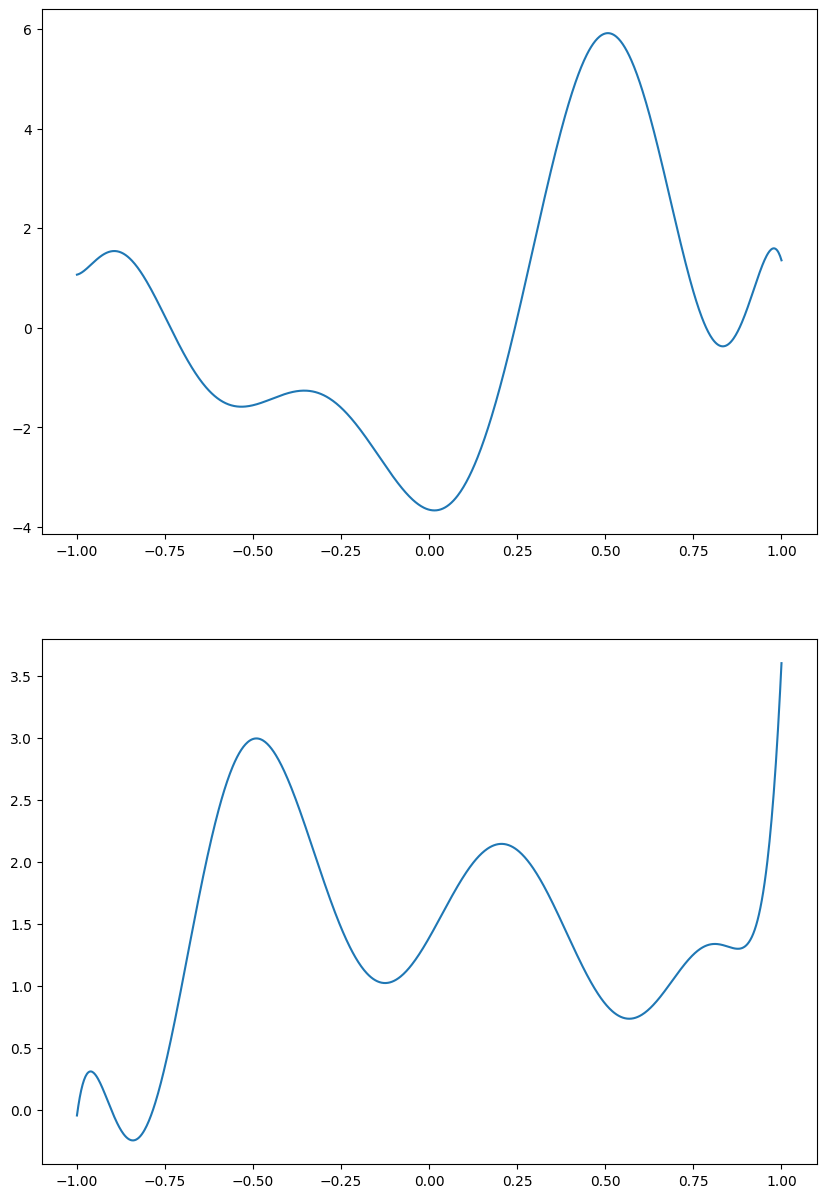

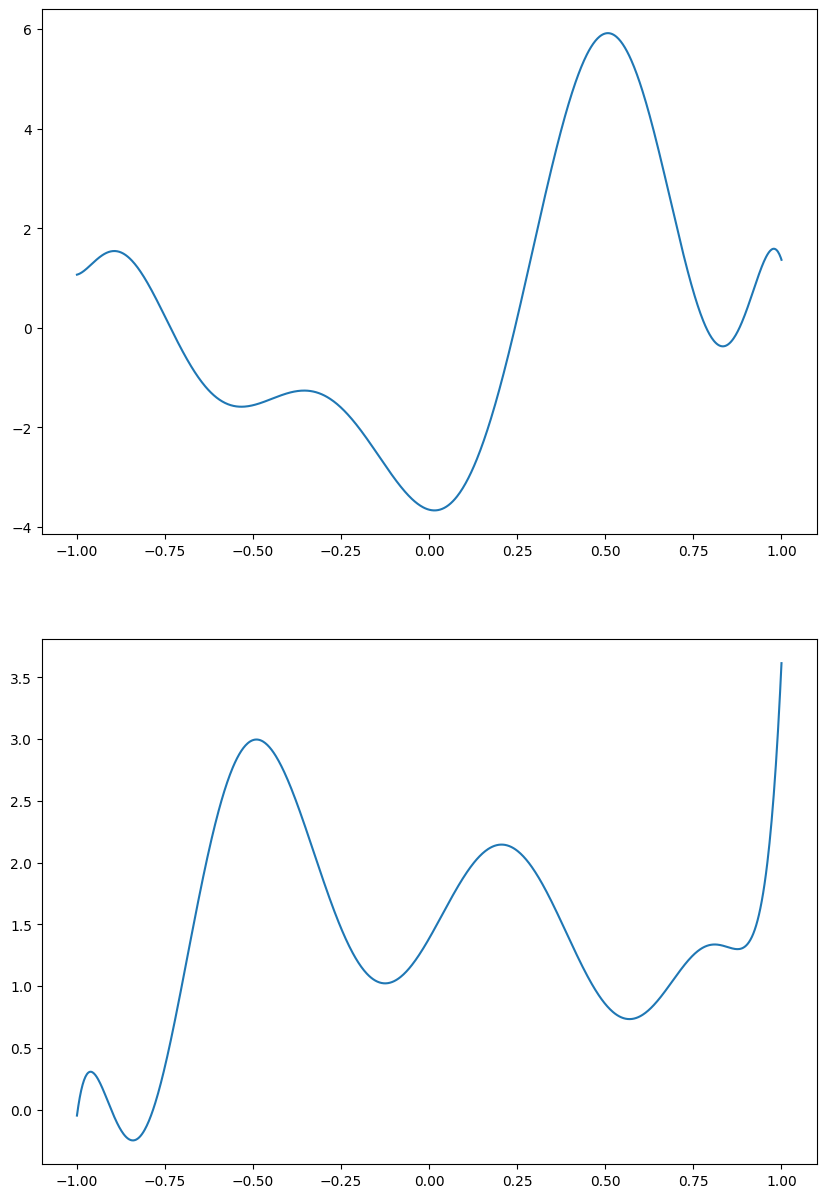

In [ ]:
layer = KAN_Layer_cheb(1,2,10)
x = torch.linspace(-1, 1, 1000).reshape(-1, 1)
y = layer.forward(x)
fig, ax = plt.subplots(2, figsize=(10,15))
for i in range(2):
 ax[i].plot(x.reshape(-1), y[:,i].detach())

layer.extend(10)
x = torch.linspace(-1, 1, 1000).reshape(-1, 1)
y = layer.forward(x)
fig, ax = plt.subplots(2, figsize=(10,15))
for i in range(2):
 ax[i].plot(x.reshape(-1), y[:,i].detach())

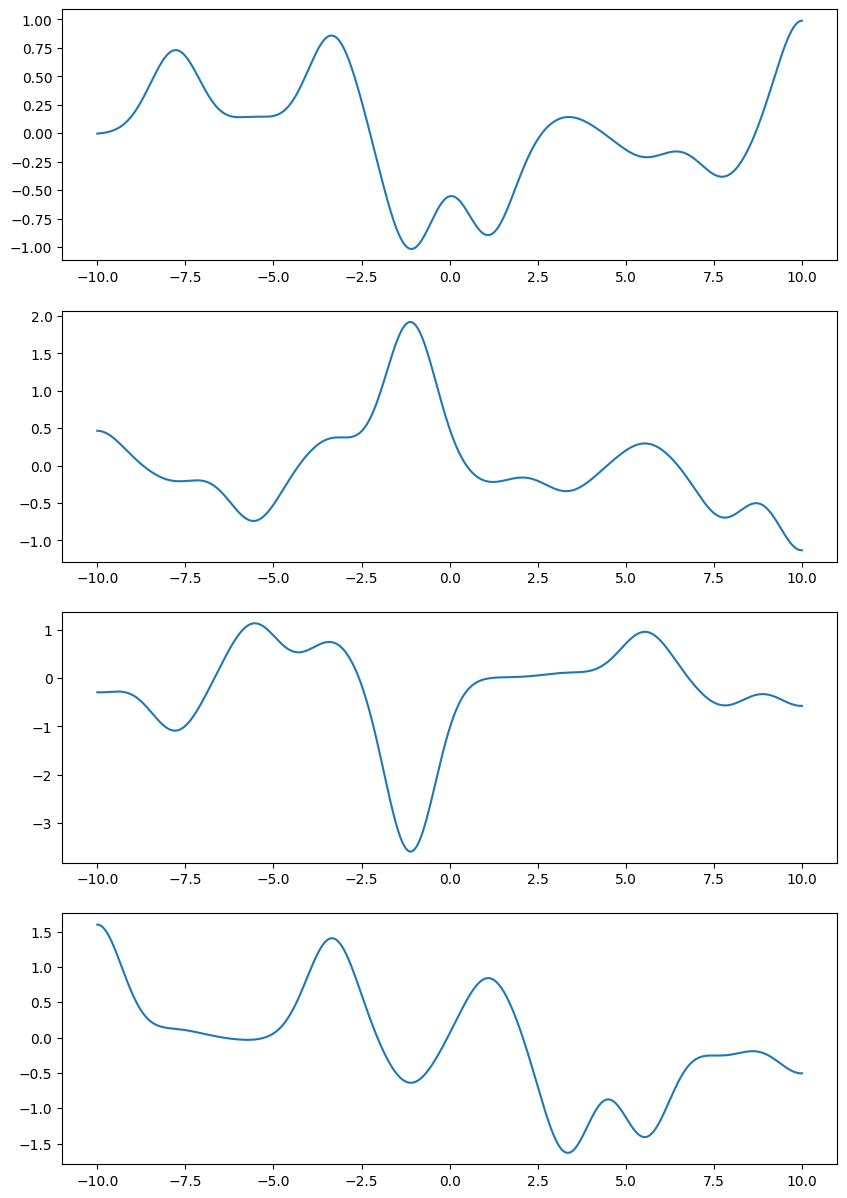

In [ ]:
layer = KAN_Layer_normal_dist(1,4,-10,10,10)
x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
y = layer.forward(x)
fig, ax = plt.subplots(4, figsize=(10,15))
for i in range(4):
 ax[i].plot(x.reshape(-1), y[:,i].detach())

In [ ]:
class KAN():
  def __init__():
    pass

In [ ]:
class KAN_normal_dist(KAN):
  def __init__(self, l):
    torch.manual_seed(42)
    self.layers = []
    for i in range(len(l)-1):
      self.layers.append(KAN_Layer_normal_dist(l[i],l[i+1],-12, 12, 30)) #later need to write extend func for Basic_func class
  def forward(self, x): #x = [samples, features]
    for layer in self.layers:
      x = layer.forward(x)
    return x
  def print(self, layer_num):
    x = torch.linspace(-10,10,1000)
    with torch.no_grad():
      fig, ax = plt.subplots(self.layers[layer_num].input_units, self.layers[layer_num].output_units, figsize=(15,8))
      ax = np.array(ax)
      ax = ax.reshape(self.layers[layer_num].input_units, self.layers[layer_num].output_units)
      for i in range(self.layers[layer_num].input_units):
        for j in range(self.layers[layer_num].output_units):
          y = self.layers[layer_num].basis_list[(i,j)].eval(x)
          ax[i,j].plot(x,y, label=f"l_n={layer_num};i={i};j={j}")
          ax[i,j].legend()
    plt.show()
    print(f"END of layer_num = {layer_num}")

In [ ]:
class KAN_fourier(KAN):
  def __init__(self, l):
    torch.manual_seed(42)
    self.layers = []
    for i in range(len(l)-1):
      self.layers.append(KAN_Layer_fourier(l[i],l[i+1],30)) #later need to write extend func for Basic_func class
  def forward(self, x): #x = [samples, features]
    for layer in self.layers:
      x = layer.forward(x)
    return x
  def print(self, layer_num):
    x = torch.linspace(-1.5,1.5,500)
    with torch.no_grad():
      fig, ax = plt.subplots(self.layers[layer_num].input_units, self.layers[layer_num].output_units, figsize=(15,8))
      ax = np.array(ax)
      ax = ax.reshape(self.layers[layer_num].input_units, self.layers[layer_num].output_units)
      for i in range(self.layers[layer_num].input_units):
        for j in range(self.layers[layer_num].output_units):
          y = self.layers[layer_num].basis_list[(i,j)].eval(x)
          ax[i,j].plot(x,y, label=f"l_n={layer_num};i={i};j={j}")
          ax[i,j].legend()
    plt.show()
    print(f"END of layer_num = {layer_num}")
  def extend(self, num):
    for layer in (self.layers):
      layer.extend(num)

In [ ]:
class KAN_cheb(KAN):
  def __init__(self, l):
    torch.manual_seed(42)
    self.layers = []
    for i in range(len(l)-1):
      self.layers.append(KAN_Layer_cheb(l[i],l[i+1],10)) #later need to write extend func for Basic_func class
  def forward(self, x): #x = [samples, features]
    for layer in self.layers:
      x = layer.forward(x)
    return x
  def print(self, layer_num):
    x = torch.linspace(-1,1,500)
    with torch.no_grad():
      fig, ax = plt.subplots(self.layers[layer_num].input_units, self.layers[layer_num].output_units, figsize=(15,8))
      ax = np.array(ax)
      ax = ax.reshape(self.layers[layer_num].input_units, self.layers[layer_num].output_units)
      for i in range(self.layers[layer_num].input_units):
        for j in range(self.layers[layer_num].output_units):
          y = self.layers[layer_num].basis_list[(i,j)].eval(x)
          ax[i,j].plot(x,y, label=f"l_n={layer_num};i={i};j={j}")
          ax[i,j].legend()
    plt.show()
    print(f"END of layer_num = {layer_num}")
  def extend(self, num):
    for layer in (self.layers):
      layer.extend(num)

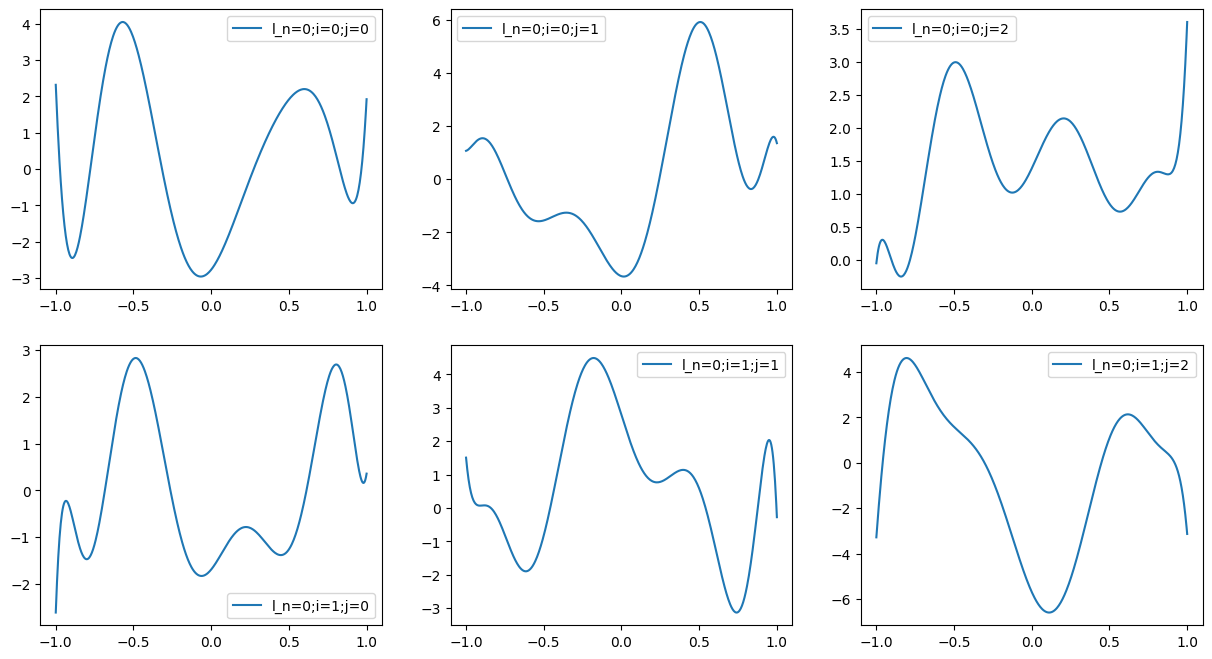

END of layer_num = 0


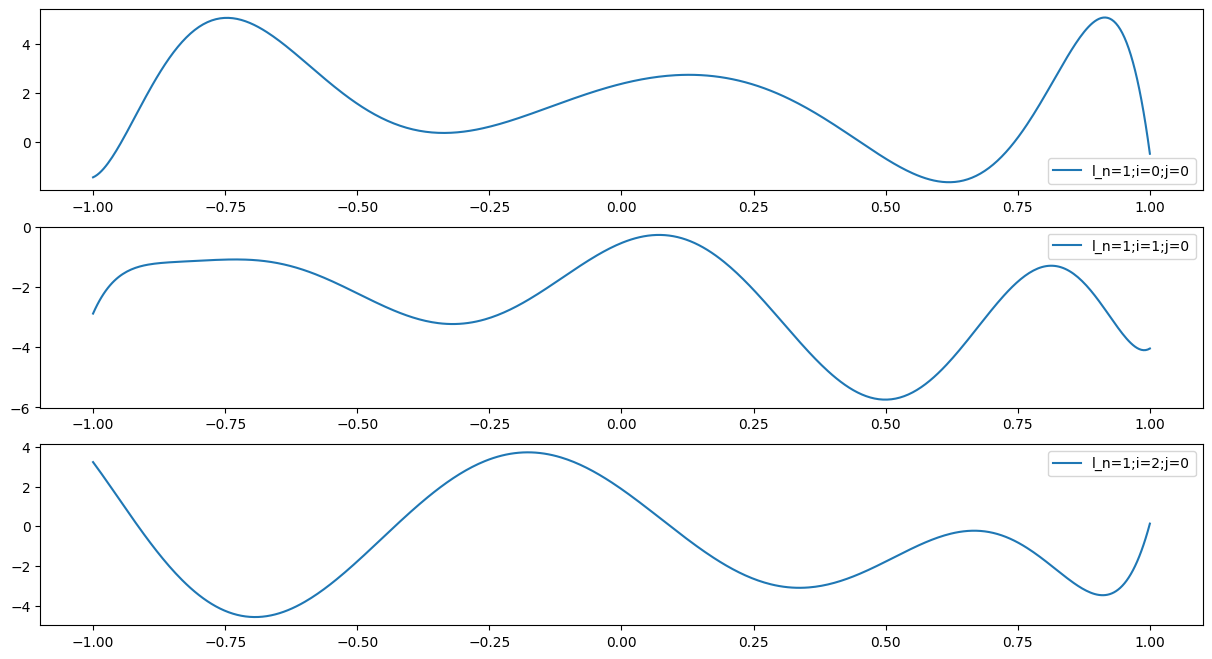

END of layer_num = 1


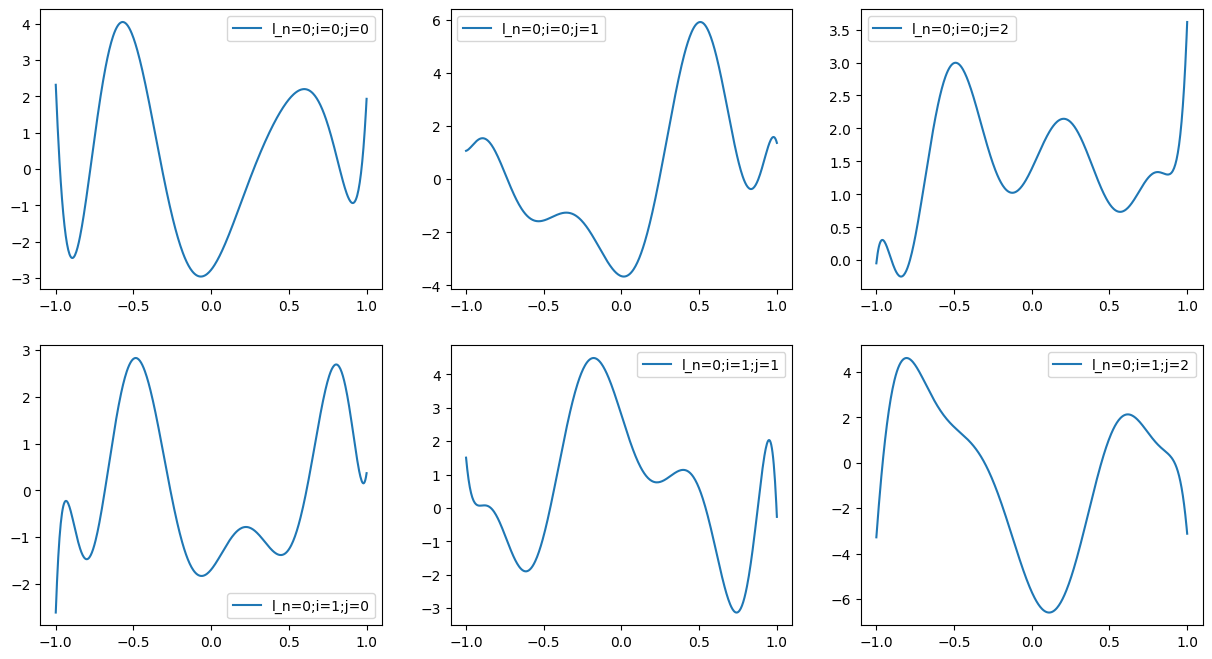

END of layer_num = 0


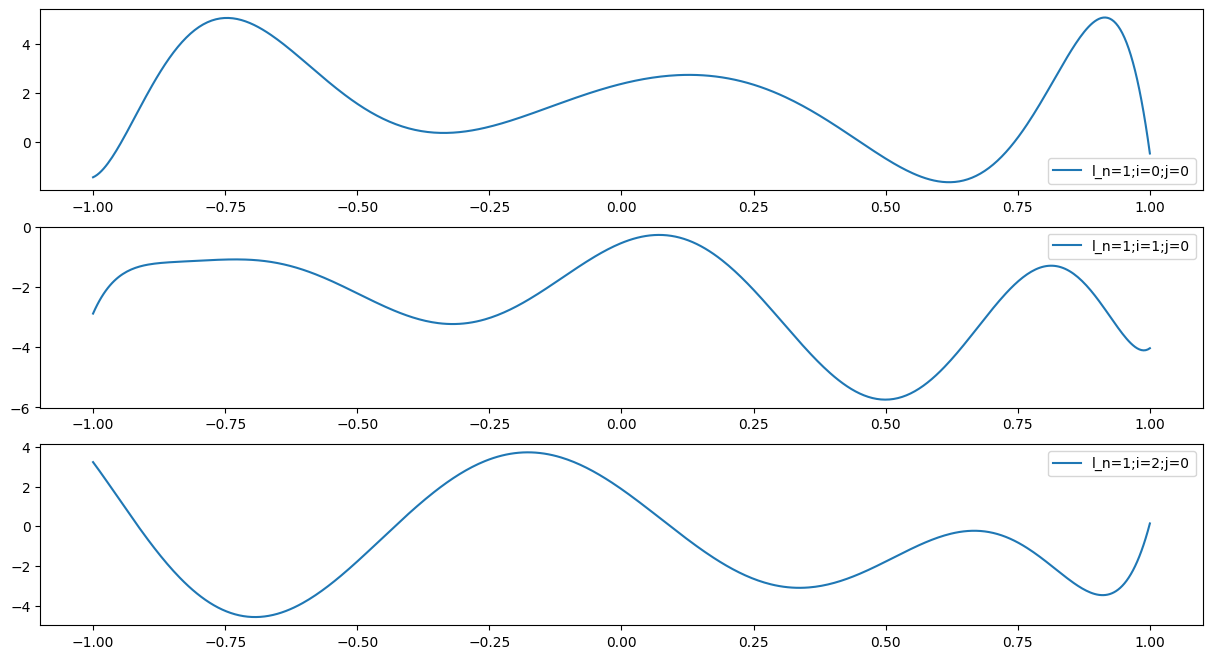

END of layer_num = 1


In [ ]:
model = KAN_cheb([2,3,1])
model.print(0)
model.print(1)

model.extend(10)
model.print(0)
model.print(1)

In [ ]:
class optimizer_normal_dis():
    def __init__(self, kan : KAN, lr=0.001):
        self.kan = kan
        self.lr = lr
    def step_with_zero_grad(self):
        for layer in self.kan.layers:
          for i in range(layer.input_units):
            for j in range(layer.output_units):
              with torch.no_grad():
                layer.basis_list[(i,j)].coef_ -= layer.basis_list[(i,j)].coef_.grad*self.lr
                layer.basis_list[(i,j)].var -= layer.basis_list[(i,j)].var.grad*self.lr
                layer.basis_list[(i,j)].coef_.grad.zero_()
                layer.basis_list[(i,j)].var.grad.zero_()

In [ ]:
class optimizer_fourier():
    def __init__(self, kan : KAN):
        self.kan = kan
    def step_with_zero_grad(self, lr=0.001):
        for layer in self.kan.layers:
          for i in range(layer.input_units):
            for j in range(layer.output_units):
              with torch.no_grad():
                layer.basis_list[(i,j)].coef_ -= layer.basis_list[(i,j)].coef_.grad*lr
                layer.basis_list[(i,j)].coef_.grad.zero_()

In [ ]:
class optimizer_cheb():
    def __init__(self, kan : KAN):
        self.kan = kan
    def step_with_zero_grad(self, lr=0.001):
        for layer in self.kan.layers:
          for i in range(layer.input_units):
            for j in range(layer.output_units):
              with torch.no_grad():
                layer.basis_list[(i,j)].coef_ -= layer.basis_list[(i,j)].coef_.grad*lr
                layer.basis_list[(i,j)].coef_.grad.zero_()

In [ ]:
def train(kan, x, y, lr=0.01, num=3000):
  loss_list = []
  flag = False
  count = 0
  optim = optimizer_cheb(kan)
  for i in (range(num)):
    count+=1
    pred = kan.forward(x)
    loss = (abs(y- pred)).sum()/y.shape[0]
    loss.backward()
    print(len(kan.layers[0].basis_list[(0,0)].coef_), kan.layers[0].basis_list[(0,0)].initial_num_of_functions)
    if i > 1 and loss_list[-1] < loss.item() and count > 40:
      kan.extend(2)
      print("Loss:",loss.item())
      count = 0
      lr = lr/1.1
      continue
    loss_list.append(loss.item())
    print("Loss:",loss.item())
    optim.step_with_zero_grad(lr)
  return loss_list

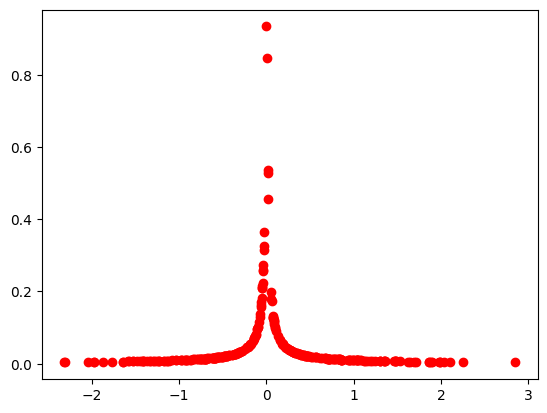

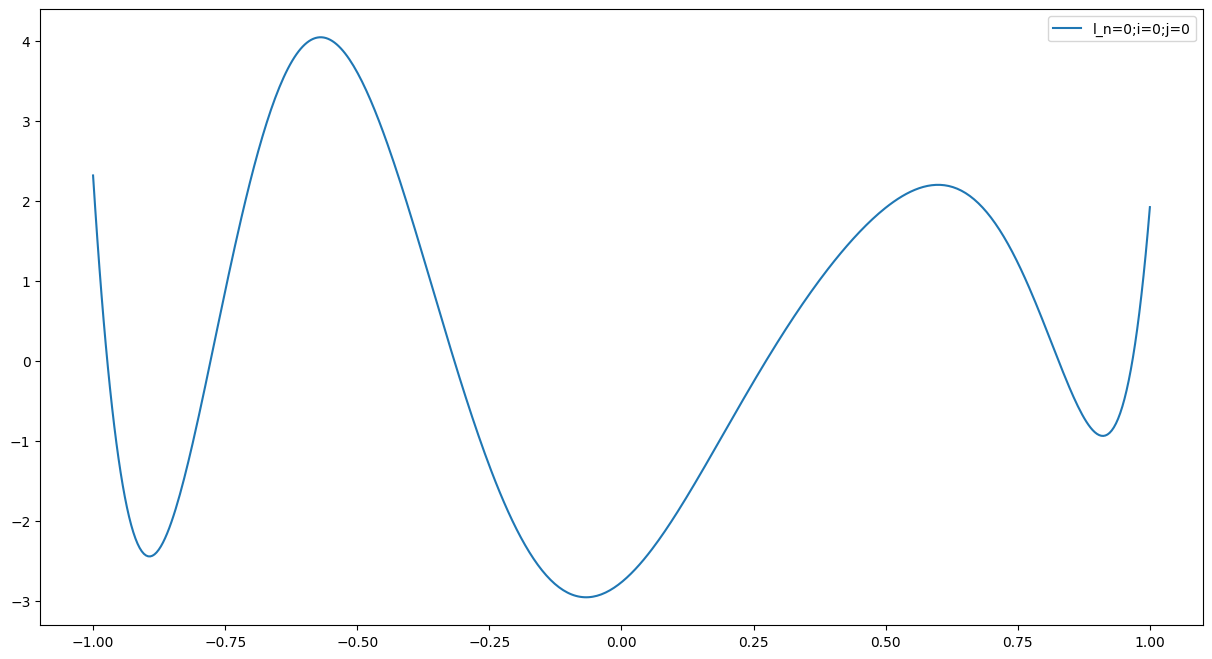

END of layer_num = 0


In [ ]:
x = torch.randn(300).reshape(-1,1)
y = torch.tanh(x*100)/(x*100).reshape(-1,1)
plt.scatter(x, y, color = "red")
plt.show()
kan = KAN_cheb([1,1])
kan.print(0)

In [ ]:
loss_list = train(kan, x, y, lr = 0.1, num=2000)

10 10
Loss: 4082.869411175951
10 10
Loss: 19034040.064479455
10 10
Loss: 450751.03064060735
10 10
Loss: 19034005.46176713
10 10
Loss: 450785.95735473366
10 10
Loss: 19033969.53896348
10 10
Loss: 450820.83607705566
10 10
Loss: 19033934.854509592
10 10
Loss: 450855.73737859377
10 10
Loss: 19033900.382324405
10 10
Loss: 450890.5885906225
10 10
Loss: 19033865.71092642
10 10
Loss: 450925.47076925886
10 10
Loss: 19033831.357399963
10 10
Loss: 450960.3684080343
10 10
Loss: 19033795.014847804
10 10
Loss: 450995.22633645264
10 10
Loss: 19033760.511985485
10 10
Loss: 451030.15287626395
10 10
Loss: 19033725.90843985
10 10
Loss: 451065.0050694399
10 10
Loss: 19033691.482311867
10 10
Loss: 451099.8849301677
10 10
Loss: 19033656.096207667
10 10
Loss: 451134.81112220336
10 10
Loss: 19033620.63657942
10 10
Loss: 451169.6621940872
10 10
Loss: 19033586.397753812
10 10
Loss: 451204.59453804704
10 10
Loss: 19033551.57160175
10 10
Loss: 451239.4468820497
10 10
Loss: 19033516.865732636
10 10
Loss: 451274.29

In [ ]:
min(loss_list)

0.004995500545017421

In [ ]:
#0.005756042742480834
#0.003343995492905378

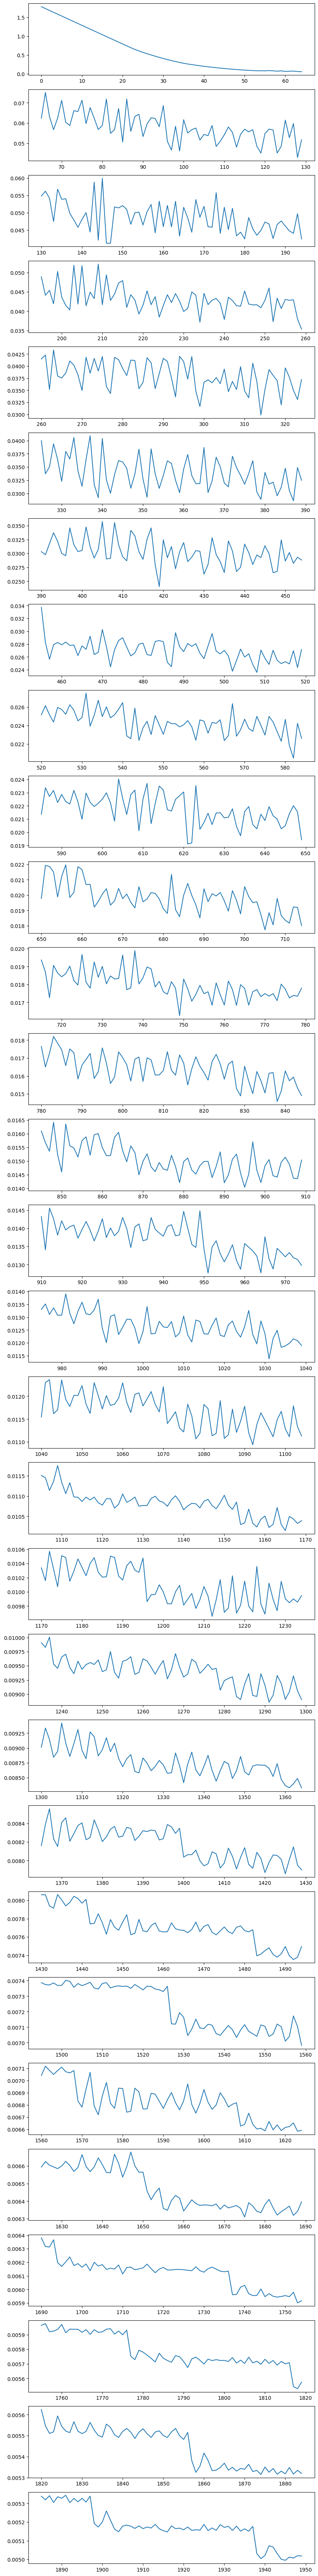

In [ ]:
n = 30
fig, ax = plt.subplots(n, 1, figsize=(10,n*3))
for i in range(n):
  ax[i].plot(range(len(loss_list)//n*i, len(loss_list)//n*(i+1)),  loss_list[len(loss_list)//n*i:len(loss_list)//n*(i+1)])

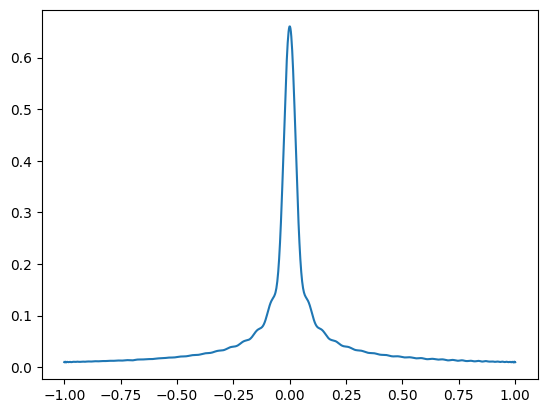

In [ ]:
plt.plot(x, kan.forward(x).detach())
plt.show()

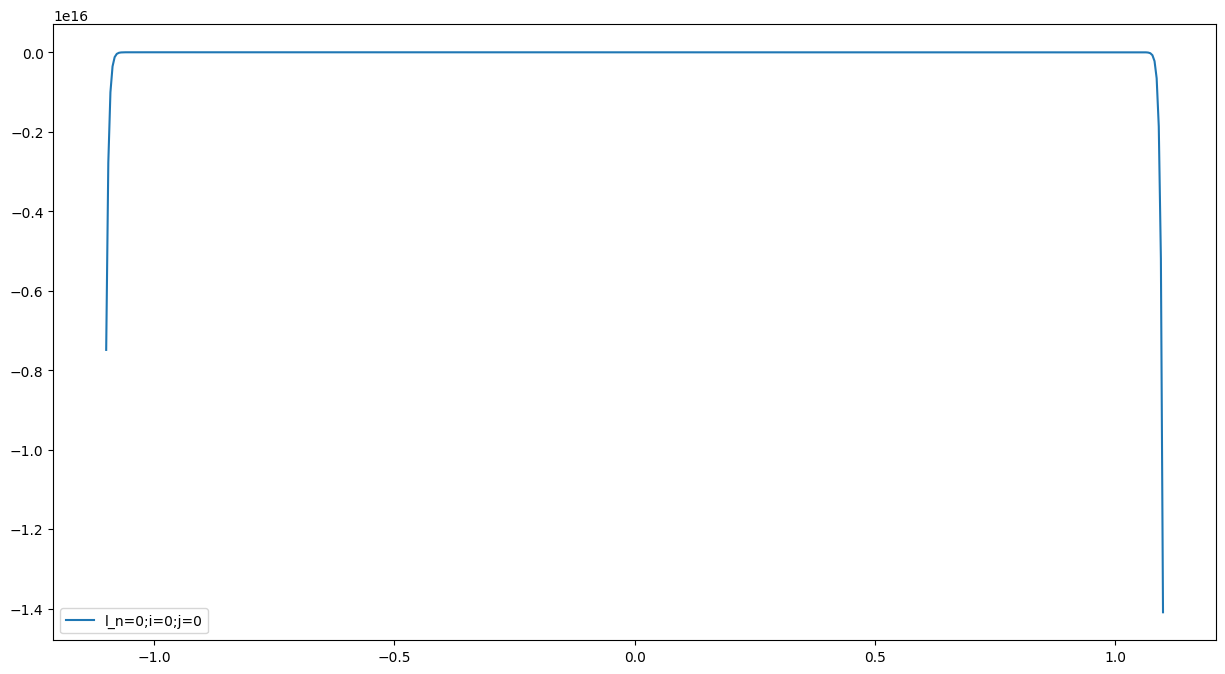

END of layer_num = 0


In [ ]:
kan.print(0)

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(2, 200)
    self.linear2 = torch.nn.Linear(200, 1)
  def forward(self, x):
    x = self.linear1(x)
    x = torch.nn.ReLU()(x)
    x = self.linear2(x)
    return x
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(5000):
    model.train()
    train_loss = 0.0

    optimizer.zero_grad()
    mean = model(x)

    # Convert log variance to variance for the loss

    # print(torch.mean(batch_y[:, -5:]).shape, mean.squeeze(-1).shape)

    loss = (abs(y- mean)).sum()/y.shape[0]
    loss.backward()
    optimizer.step()

    train_loss = loss.item()
    print(train_loss)

103.4633560180664
104.37075805664062
117.04447937011719
104.86361694335938
108.38622283935547
111.30632781982422
107.2686538696289
104.07261657714844
105.7639389038086
107.46713256835938
106.64971160888672
104.643798828125
103.99174499511719
105.2427978515625
105.52802276611328
105.26468658447266
104.45751190185547
103.69903564453125
104.38925170898438
104.65734100341797
104.3497543334961
104.25816345214844
103.77277374267578
103.88165283203125
104.2478256225586
103.89775085449219
103.94161987304688
103.77156066894531
103.61196899414062
103.97742462158203
103.73900604248047
103.66294860839844
103.7392349243164
103.5664291381836
103.75765228271484
103.66242218017578
103.53435516357422
103.62471008300781
103.5708236694336
103.62924194335938
103.58416748046875
103.48255920410156
103.55602264404297
103.55229949951172
103.57376098632812
103.49740600585938
103.48123168945312
103.52830505371094
103.53096008300781
103.51114654541016
103.4658203125
103.4903793334961
103.5141372680664
103.496246

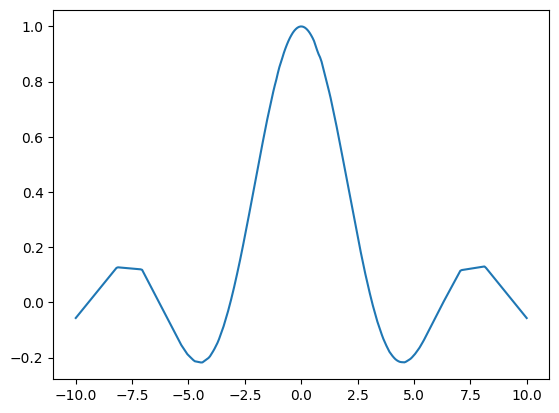

In [ ]:
plt.plot(x, model(x).detach())